In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import gaussian_kde, norm
import ipywidgets as widgets
from IPython.display import display, clear_output

print("Running with PyMC version:", pm.__version__)


Running with PyMC version: 5.22.0


In [2]:
unet_macs_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples'
swin_macs_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples'

unet_ps_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ps_samples'
swin_ps_loss_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ps_samples'

metrics = ['loss', 'specificity', 'sensitivity', 'IoU', 'f1_score', 'Hausdorff_distance']
maximize_metrics = {'specificity', 'sensitivity', 'IoU', 'f1_score'}

unet_macs_output_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples'
swin_macs_output_dir = r'N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples'

In [3]:
def read_metrics_as_array(directory, metrics):
    files = sorted([f for f in os.listdir(directory) if f.endswith('.csv')])
    data_list = []
    
    metric_names = []
    for metric in metrics:
        metric_names.append(metric)
        metric_names.append('val_' + metric)

    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        file_data = []

        for name in metric_names:
            if name in df.columns:
                file_data.append(df[name].values)
            else:
                # Fill with NaNs if column is missing
                file_data.append(np.full(len(df), np.nan))
        
        # Transpose so shape is (epochs, metrics)
        file_data = np.stack(file_data, axis=1)  # shape: (epochs, num_metrics)
        data_list.append(file_data)

    # Convert to a 3D array: (files, epochs, metrics)
    data_array = np.stack(data_list, axis=0)

    # Build lookup dict
    lookup = {name: idx for idx, name in enumerate(metric_names)}

    return data_array, lookup, files


In [4]:
def plot_losses(loss_array, metrics, metric_lookup, output_dir, show_plot=False):
    epochs = loss_array.shape[1]
    num_metrics = len(metrics)

    plt.figure(figsize=(20, 2.5))  # Square layout
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)

        # Training metric
        for j in range(loss_array.shape[0]):
            plt.plot(range(epochs), loss_array[j, :, metric_lookup[metric]], color='lightblue', linewidth=1)

        train_mean = np.nanmean(loss_array[:, :, metric_lookup[metric]], axis=0)
        
        # Validation metric
        val_metric = 'val_' + metric
        if val_metric in metric_lookup:
            for j in range(loss_array.shape[0]):
                plt.plot(range(epochs), loss_array[j, :, metric_lookup[val_metric]], color='peachpuff', linewidth=1)

            val_mean = np.nanmean(loss_array[:, :, metric_lookup[val_metric]], axis=0)
            plt.plot(range(epochs), train_mean, color='tab:blue', label=f'train', linewidth=2)
            plt.plot(range(epochs), val_mean, color='tab:orange', label=f'val', linewidth=2)

        plt.title(metric)
        plt.ylim(0,1)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        #plt.legend(loc='upper right')
        plt.grid(True)
        plt.gca().set_aspect('auto')  # Square plot per metric (approx)
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'losses_plot.png')
    plt.savefig(output_path)
    if show_plot:
        plt.show()
    plt.close()
    print(f"Plot saved to {output_path}")




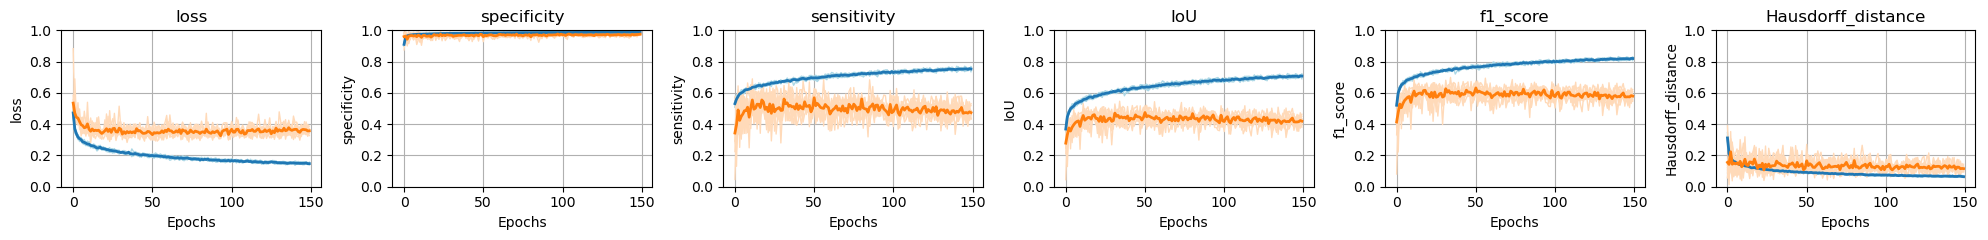

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ae_samples\losses_plot.png


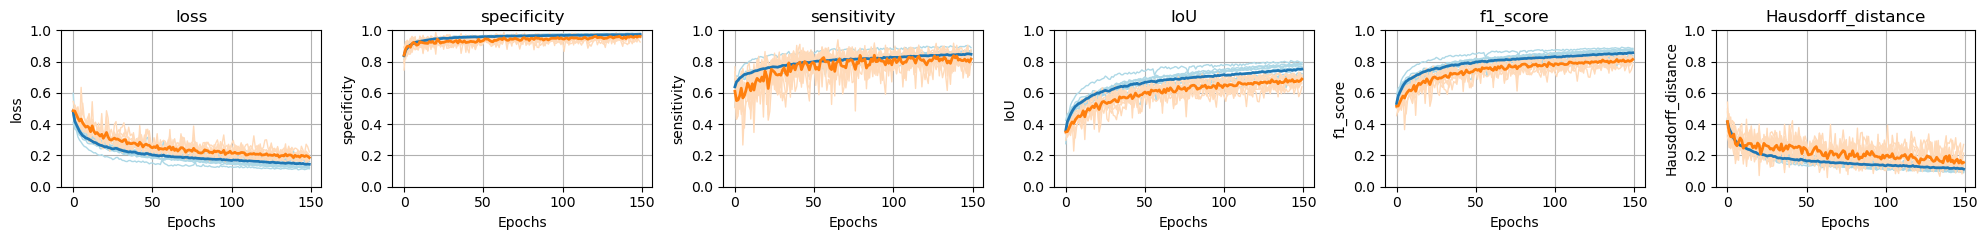

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ae_samples\losses_plot.png


C:\Users\castad001\AppData\Local\Temp\ipykernel_10648\3993307321.py:14: RuntimeWarning: Mean of empty slice
  train_mean = np.nanmean(loss_array[:, :, metric_lookup[metric]], axis=0)


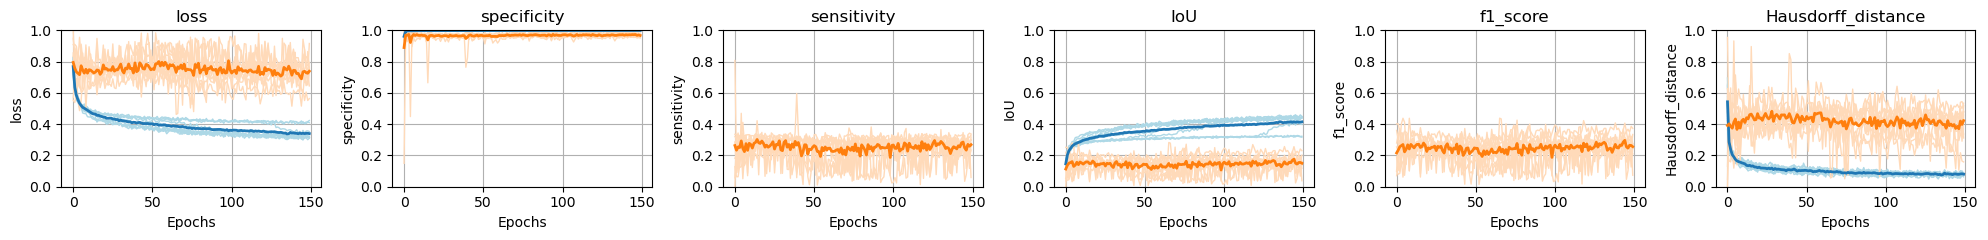

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\unet_ps_samples\losses_plot.png


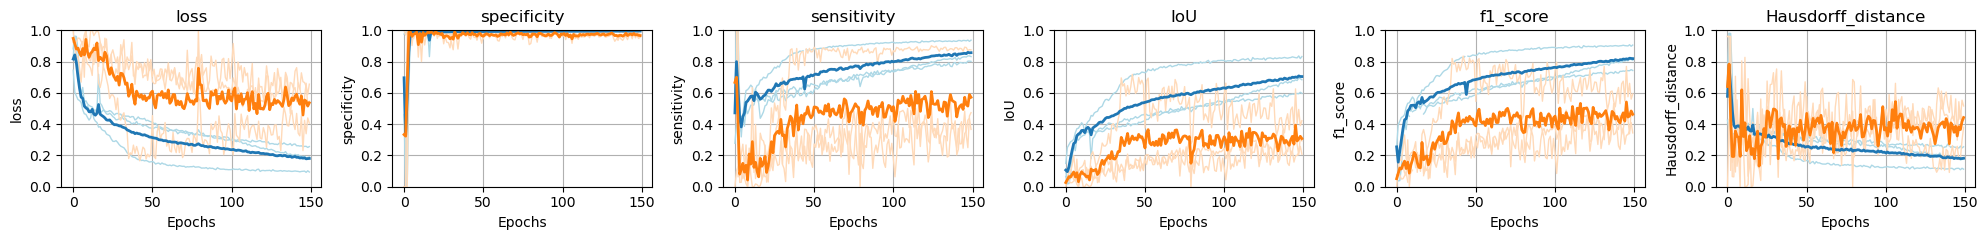

Plot saved to N:\isipd\projects\p_planetdw\data\methods_test\logs\swin_ps_samples\losses_plot.png


In [7]:
unet_macs, unet_macs_metric_lookup, unet_macs_file_names = read_metrics_as_array(unet_macs_loss_dir, metrics)
swin_macs, swin_macs_metric_lookup, swin_macs_file_names = read_metrics_as_array(swin_macs_loss_dir, metrics)
unet_ps, unet_ps_metric_lookup, unet_ps_file_names = read_metrics_as_array(unet_ps_loss_dir, metrics)
swin_ps, swin_ps_metric_lookup, swin_ps_file_names = read_metrics_as_array(swin_ps_loss_dir, metrics)

plot_losses(unet_macs, metrics, unet_macs_metric_lookup, unet_macs_output_dir, show_plot=True)
plot_losses(swin_macs, metrics, swin_macs_metric_lookup, swin_macs_output_dir, show_plot=True)
plot_losses(unet_ps, metrics, unet_ps_metric_lookup, unet_ps_loss_dir, show_plot=True)
plot_losses(swin_ps, metrics, swin_ps_metric_lookup, swin_ps_loss_dir, show_plot=True)

In [8]:
def get_best_metric(data_array, metric_lookup, metric):
    """
    Get the best metric values across epochs for each file in the data array.
    Args:
        data_array (np.ndarray): 3D array of shape (files, epochs, metrics).
        metric_lookup (dict): Dictionary mapping metric names to their indices.
        metric (str): The metric to evaluate.
        maximize_metrics (set): Set of metrics that should be maximized.
    Returns:
        np.ndarray: Array of best metric values for each file.
    """

    best_values = []


    for i in range(data_array.shape[0]):

        losses = data_array[i, :, metric_lookup['loss']]
        values = data_array[i, :, metric_lookup[metric]]


        best_epoch = np.nanargmin(losses)
        #print(f'best epoch; {best_epoch}')

        best_value = values[best_epoch]
        #print('best value:', best_value)

        best_values.append(best_value)

    return np.array(best_values)

def interpret_bayes_factor(bf):
    """Return Jeffreys-style verbal label for a Bayes factor > 1."""
    if bf < 3:
        return "anecdotal"
    elif bf < 10:
        return "moderate"
    elif bf < 30:
        return "strong"
    elif bf < 100:
        return "very strong"
    else:
        return "extreme"

def BEST(combined_array, group_one, group_two, metric, minimal_metrcis = ['val_loss', 'loss', 'val_Hausdorff_distance', 'Hausdorff_distance'], group_one_label='unet', group_two_label='swin', plot=True):

    """
    Perform Bayesian estimation of the difference in means and standard deviations
    between two groups using Student's t-distribution (Krischke 2005).
    Args:
        combined_array (pd.DataFrame): DataFrame containing the metric values and group labels.
        group_one (np.ndarray): values of group 1.
        group_two (np.ndarray): values of group 2.
    Returns:
        None
    """
    metric_values = combined_array[metric].values

    mu_m = metric_values.mean()
    mu_s = metric_values.std()*2

    sigma_low = 10**-1
    sigma_high = 10

    with pm.Model() as model:
        group1_mean = pm.Normal(f'{group_one_label}_mean', mu=mu_m, sigma=mu_s)
        group2_mean = pm.Normal(f'{group_two_label}_mean', mu=mu_m, sigma=mu_s)

        group1_std = pm.Uniform(f'{group_one_label}_std', lower=sigma_low, upper=sigma_high)
        group2_std = pm.Uniform(f'{group_two_label}_std', lower=sigma_low, upper=sigma_high)

        nu_minus_one = pm.Exponential('nu_minus_one', lam=1/29)
        nu = pm.Deterministic('nu', nu_minus_one + 1)
        nu_log10 = pm.Deterministic('nu_log10', np.log10(nu))

        lambda_group1 = group1_std**-2
        lambda_group2 = group2_std**-2

        group_one_obs = pm.StudentT(f'{group_one_label}_obs', mu=group1_mean, lam=lambda_group1, nu=nu, observed=group_one)
        group_two_obs = pm.StudentT(f'{group_two_label}_obs', mu=group2_mean, lam=lambda_group2, nu=nu, observed=group_two)

        diff_of_means = pm.Deterministic('diff_of_means', group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic('diff_of_stds', group1_std - group2_std)
        effect_size = pm.Deterministic('effect_size', diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

        idata = pm.sample(tune=1000, draws=2000, chains=4, target_accept=0.95, return_inferencedata=True)

    if plot:
        print('\n---- Posterior for the means and stds ----')

        az.plot_posterior(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean', f'{group_one_label}_std', f'{group_two_label}_std', 'nu_log10', 'nu'])
        plt.show()

        print('\n---- Posterior for the differences and effect size ----')

        az.plot_posterior(idata, var_names=['diff_of_means', 'diff_of_stds', 'effect_size'], ref_val=0)
        plt.show()

        print('\n---- Forests for means, stds, and nu ----')
        
        az.plot_forest(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean'])
        plt.show()

        print('\n---- Forests for stds and nu ----')

        az.plot_forest(idata, var_names=[f'{group_one_label}_std', f'{group_two_label}_std', 'nu'])
        plt.show()

    print('\n---- Model summary ----')

    summary = az.summary(idata, var_names=[f'{group_one_label}_mean', f'{group_two_label}_mean','diff_of_means', 'diff_of_stds', 'effect_size'])
    print(summary)

    print('\n---- Savage-Dickey Bayes Factor ----\n')

    
    # Posterior density at δ = 0  (KDE is still appropriate here)
    diff_samples = idata.posterior['diff_of_means'].values.flatten()
    posterior_kde            = gaussian_kde(diff_samples)
    posterior_density_at_zero = posterior_kde.evaluate(0)[0]

    # Analytical prior density at δ = 0  (δ ~ Normal(0, √2·mu_s))
    prior_sd_diff            = np.sqrt(2) * mu_s
    prior_density_at_zero    = norm.pdf(0, loc=0, scale=prior_sd_diff)

    # Bayes factors
    BF_01 = posterior_density_at_zero / prior_density_at_zero   # H₀ over H₁
    BF_10 = 1 / BF_01                                           # H₁ over H₀

    metric_is_lower_better = metric  in minimal_metrcis
    mean_diff = diff_samples.mean()   # μ_unet − μ_swin

    if BF_10 > 1:            # data support the alternative
        # who wins, given the metric direction?
        if (not metric_is_lower_better and mean_diff > 0) or \
        (    metric_is_lower_better and mean_diff < 0):
            winner, loser = group_one_label, group_two_label
        else:
            winner, loser = group_two_label, group_one_label

        label = interpret_bayes_factor(BF_10)
        print(f"p(δ=0)        : {prior_density_at_zero:.4g}")
        print(f"p(δ=0 | data) : {posterior_density_at_zero:.4g}")
        print(f"Evidence for {winner} outperforming {loser}: "
            f"BF₁₀ = {BF_10:.4g}  ({label})\n")

    else:                     # data support the null
        label = interpret_bayes_factor(BF_01)
        print(f"p(δ=0)        : {prior_density_at_zero:.4g}")
        print(f"p(δ=0 | data) : {posterior_density_at_zero:.4g}")
        print(f"Evidence for no difference (H₀): "
            f"BF₀₁ = {BF_01:.4g}  ({label})")


[0.3812412  0.38870388 0.47546616 0.44583207 0.47902238 0.44609573
 0.45814842 0.43761808 0.44007346 0.41527733]


C:\Users\castad001\AppData\Local\Temp\ipykernel_10648\2989344593.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


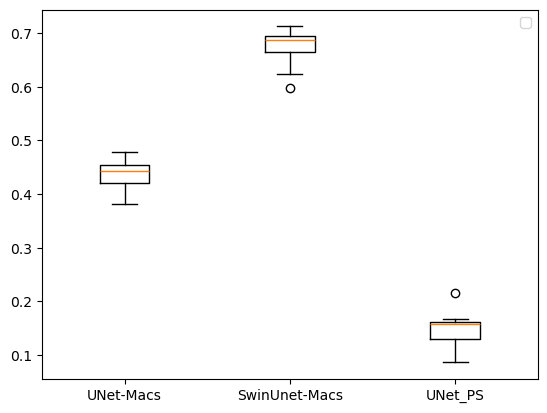

In [9]:
full_metric = 'val_IoU'

unet_macs_best = get_best_metric(unet_macs, unet_macs_metric_lookup, full_metric)
swin_macs_best = get_best_metric(swin_macs, swin_macs_metric_lookup, full_metric)

unet_ps_best = get_best_metric(unet_ps, unet_ps_metric_lookup, full_metric)
print(unet_macs_best)

plt.boxplot([unet_macs_best, swin_macs_best, unet_ps_best], tick_labels=['UNet-Macs', 'SwinUnet-Macs', 'UNet_PS'], showfliers=True)
plt.legend()
plt.show()

In [10]:
tabs     = []      # the Output widgets (one per metric)
tab_titles = []    # used to label the tab headers

for metric in metrics:

    full_metric = 'val_' + metric if not metric.startswith('val_') else metric
    out = widgets.Output()          # each metric gets its own Output “sandbox”

    with out:                       # everything inside goes only to this tab
        clear_output(wait=True)     # keeps the tab clean on reruns

        print(f"### Processing metric: {full_metric}\n")

        unet_macs_best = get_best_metric(unet_macs, unet_macs_metric_lookup, full_metric)
        swin_macs_best = get_best_metric(swin_macs, swin_macs_metric_lookup, full_metric)

        #plt.boxplot([unet_best, swin_best], labels=['UNet', 'Swin Transformer'], showfliers=True)



        BEST(
            pd.concat([
                pd.DataFrame({full_metric: unet_best, 'group': 'U-Net | Aerial'}),
                pd.DataFrame({full_metric: swin_best, 'group': 'Swin U-Net | Aerial'}),
            ]).reset_index(drop=True),
            unet_best, swin_best, full_metric,
            plot=True                                    
        )

    # keep references so we can build the Tab afterwards
    tabs.append(out)
    tab_titles.append(full_metric)

tab_widget = widgets.Tab(children=tabs)

for i, title in enumerate(tab_titles):
    tab_widget.set_title(i, title)   # label each tab

display(tab_widget)


In [11]:
import os
import json
from pathlib import Path
from collections import defaultdict

def filter_and_remap_splits(folder_src: str,
                            folder_dst: str,
                            split_dict: dict) -> dict:
    """
    • Walk through *every file* in `folder_src` (sorted for determinism).
    • If that file also exists in `folder_dst`, look up:
        – its index in the *source* folder
        – the split group (train / test / val) that index belongs to
        – its index in the *destination* folder
    • Append the destination index to a new list under the same split group.
    • Any file missing from `folder_dst` is silently skipped.

    Returns
    -------
    dict  –  same keys as `split_dict`, but containing only the
             files that still exist in both folders, with indices
             now referring to `folder_dst`.
    """

   
    # Sorted listings give stable, reproducible indices
    src_files = sorted(os.listdir(folder_src))
    dst_files = sorted(os.listdir(folder_dst))

    # Fast filename ➜ index lookup for folder_dst
    dst_index_of = {name: i for i, name in enumerate(dst_files)}

    # Prepare the output dict with the same split keys
    updated = {k: [] for k in split_dict}

    for group, idx_list in split_dict.items():
        for idx in idx_list:
            if idx >= len(src_files):
                raise IndexError(
                    f"Index {idx} is out of range for source folder "
                    f"({len(src_files)} files)."
                )
            fname = src_files[idx]            # step 1
            dst_idx = dst_index_of.get(fname) # step 2
            if dst_idx is not None:
                updated[group].append(dst_idx)  # step 3

    return updated


# ---------------------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    # ── folders ────────────────────────────────────────────────────────────
    FOLDER_A = r"N:\isipd\projects\p_planetdw\data\methods_test\training_data\MACS\20250429-1208_MACS_test_utm8"   # indices in the JSON point here
    FOLDER_B = r"N:\isipd\projects\p_planetdw\data\methods_test\training_data\PS\20250604-0816_Unet_Planet_utm8"   # new target folder

    # ── your JSON split definition (load from file or paste) ───────────────
    SPLITS_JSON = """
    {
    "training_frames": [550, 28, 374, 15, 134, 462, 193, 112, 544, 341, 582, 513, 385, 24, 263, 347, 452, 249, 6, 623, 285, 11, 195, 105, 632, 608, 237, 570, 315, 143, 220, 475, 640, 625, 432, 149, 226, 402, 202, 451, 620, 255, 499, 288, 401, 246, 369, 360, 334, 345, 595, 316, 319, 168, 225, 581, 245, 63, 536, 624, 508, 503, 540, 408, 291, 426, 96, 657, 434, 375, 86, 478, 548, 524, 419, 188, 151, 37, 217, 328, 596, 407, 161, 532, 250, 318, 652, 42, 353, 39, 472, 384, 313, 493, 569, 448, 92, 70, 101, 5, 382, 3, 630, 209, 443, 234, 206, 546, 45, 644, 290, 79, 163, 264, 575, 517, 441, 587, 424, 303, 157, 591, 122, 450, 329, 572, 147, 456, 376, 483, 178, 592, 423, 377, 387, 230, 605, 236, 551, 491, 571, 75, 85, 626, 396, 616, 260, 169, 277, 185, 446, 431, 390, 90, 258, 467, 46, 340, 265, 281, 110, 29, 633, 386, 504, 490, 152, 357, 509, 205, 336, 476, 227, 97, 22, 647, 177, 515, 166, 114, 266, 180, 184, 604, 395, 354, 651, 398, 123, 567, 106, 634, 203, 58, 153, 447, 656, 321, 663, 496, 454, 224, 461, 4, 218, 528, 299, 19, 140, 179, 103, 223, 181, 113, 137, 530, 615, 573, 599, 421, 57, 568, 404, 389, 327, 50, 425, 267, 350, 485, 74, 397, 391, 338, 502, 403, 415, 579, 331, 221, 138, 637, 470, 642, 361, 229, 172, 409, 459, 55, 576, 111, 636, 535, 139, 622, 62, 135, 9, 132, 469, 545, 482, 487, 199, 593, 65, 192, 339, 500, 588, 17, 141, 44, 323, 435, 413, 439, 521, 284, 533, 175, 484, 658, 427, 643, 73, 486, 272, 349, 366, 373, 510, 531, 2, 1, 607, 216, 378, 631, 578, 242, 333, 165, 159, 392, 543, 549, 405, 312, 231, 370, 279, 102, 442, 116, 198, 38, 298, 52, 89, 617, 465, 81, 358, 522, 213, 26, 99, 562, 317, 553, 297, 614, 32, 489, 586, 668, 8, 94, 48, 160, 274, 14, 296, 16, 628, 367, 606, 326, 268, 144, 598, 121, 259, 474, 344, 270, 444, 372, 66, 660, 77, 83, 87, 262, 278, 10, 602, 257, 43, 93, 308, 563, 594, 523, 302, 115, 537, 650, 449, 239, 453, 21, 330, 519, 207, 34, 210, 150, 35, 301, 211, 31, 0, 219, 240, 414, 359, 639, 68, 351, 468, 190, 394, 365, 649, 379, 171, 148, 648, 269, 458, 305, 182, 618, 20, 584, 64, 556, 547, 53, 343, 12, 346, 154, 383, 56], 
    "testing_frames": [363, 36, 506, 557, 534, 455, 322, 155, 129, 589, 645, 238, 82, 654, 481, 418, 538, 183, 337, 311, 512, 310, 60, 107, 612, 514, 635, 276, 108, 186, 156, 201, 67, 80, 309, 460, 411, 295, 558, 662, 23, 282, 488, 664, 494, 388, 125, 477, 164, 516, 580, 69, 133, 552, 54, 286, 554, 638, 585, 368, 59, 320, 495, 27, 248, 241, 98, 560, 212, 146, 197, 208, 583, 564, 293, 518, 243, 566, 542, 232, 30, 300, 275, 173, 406, 306, 646, 204, 41, 287, 214, 501, 256, 422, 601, 292, 84, 565, 127, 136, 215, 466, 273, 420, 176, 457, 665, 667, 91, 235, 49, 539, 289, 283, 417, 603, 440, 142, 100, 429, 170, 352, 600, 348, 233, 124, 399, 117, 72, 381, 362, 520, 194, 597], 
    "validation_frames": [438, 78, 613, 332, 511, 244, 464, 471, 393, 167, 128, 661, 356, 355, 410, 364, 88, 47, 247, 109, 187, 611, 497, 436, 251, 574, 555, 619, 254, 40, 473, 335, 228, 126, 95, 119, 314, 33, 641, 61, 609, 527, 200, 191, 7, 412, 145, 621, 158, 463, 561, 610, 196, 222, 400, 653, 480, 120, 445, 130, 577, 380, 629, 304, 294, 498, 479, 430, 526, 590, 559, 51, 71, 325, 261, 13, 307, 252, 342, 162, 131, 18, 25, 416, 627, 428, 666, 507, 505, 529, 371, 118, 492, 541, 271, 659, 433, 324, 104, 437, 525, 189, 655, 76, 280, 253, 174]
    }
    """
    splits = json.loads(SPLITS_JSON)

    # ── remap & show the result ────────────────────────────────────────────
    updated = filter_and_remap_splits(FOLDER_A, FOLDER_B, splits)
    print(json.dumps(updated, indent=2))


{
  "training_frames": [
    0,
    14,
    40,
    20,
    6,
    11,
    36,
    9,
    26,
    34,
    15,
    2,
    16,
    4,
    7,
    17,
    38,
    33,
    43,
    48,
    37,
    35,
    30,
    8,
    28,
    27,
    21
  ],
  "testing_frames": [
    22,
    3,
    47,
    24,
    13,
    44,
    31,
    39,
    25,
    45
  ],
  "validation_frames": [
    41,
    1,
    29,
    19,
    23,
    12
  ]
}


In [12]:
def fit_bayesian_anova(df, metric, lower_is_better=False,
                       robust=True, hierarchical=True,
                       tune=1000, draws=2000, chains=4, target_accept=0.95):
    """
    df must have columns;  metric (float)  and  "group" (categorical/string)
    """
    y      = df[metric].values
    groups = df["group"].astype("category")
    g_idx  = groups.cat.codes.values          # 0 … K-1
    K      = int(g_idx.max() + 1)

    mu_m, mu_s        = y.mean(), y.std()*2
    sigma_low, sigma_high = 1e-1, 10

    with pm.Model() as m:
        # --- priors on the K group means -----------------------------------
        if hierarchical:          # partial-pooling variant
            mu_grand = pm.Normal("mu_grand", mu=mu_m, sigma=mu_s)
            tau       = pm.HalfNormal("tau", sigma=mu_s)
            mu        = pm.Normal("mu", mu=mu_grand, sigma=tau, shape=K)
        else:                     # independent means
            mu = pm.Normal("mu", mu=mu_m,  sigma=mu_s, shape=K)

        # --- priors on the K group stds ------------------------------------
        sigma = pm.Uniform("sigma", lower=sigma_low, upper=sigma_high, shape=K)

        # --- optional heavy-tailed likelihood ------------------------------
        nu = (pm.Exponential("nu_minus_1", 1/29) + 1) if robust else np.inf

        pm.StudentT("obs", mu=mu[g_idx], sigma=sigma[g_idx], nu=nu, observed=y)

        idata = pm.sample(tune=tune, draws=draws, chains=chains, target_accept=target_accept,
                          return_inferencedata=True)

    idata.attrs["metric"]           = metric
    idata.attrs["lower_is_better"]  = lower_is_better
    idata.attrs["groups"]           = groups.cat.categories.tolist()
    return idata

def prob_each_is_best(idata):
    """
    Return a Series whose index is group names and whose values are the
    posterior probabilities that each group has the best (min / max) mean.
    Works without the 'bottleneck' package.
    """
    metric_is_lower = idata.attrs["lower_is_better"]
    means = (
        idata.posterior["mu"]
        .stack(sample=("chain", "draw"))
        .values                              # numpy (K, N)
    )

    # index of best group in every posterior draw ---------------------------
    best_idx = means.argmin(axis=0) if metric_is_lower else means.argmax(axis=0)

    K   = means.shape[0]
    p   = np.bincount(best_idx, minlength=K) / best_idx.size  # length-K vector
    return pd.Series(p, index=idata.attrs["groups"], name="p(best)")


def pairwise_contrasts(idata, rope=None):
    means = (idata.posterior["mu"]
             .stack(sample=("chain", "draw"))
             .values)            # -> plain (K, N) ndarray
    K, N = means.shape
    names = idata.attrs["groups"]
    rows = []

    for i in range(K - 1):
        for j in range(i + 1, K):
            diff = means[i] - means[j]                # 1-D NumPy
            hdi_low, hdi_high = np.quantile(diff, [0.025, 0.975])
            prob_gt0 = (diff > 0).mean()

            row = dict(A=names[i], B=names[j],
                       mean_diff=diff.mean(),
                       hdi_low=hdi_low, hdi_high=hdi_high,
                       p_A_gt_B=prob_gt0)

            if rope is not None:
                row["p_in_rope"] = ((rope[0] < diff) & (diff < rope[1])).mean()
            rows.append(row)

    return pd.DataFrame(rows)



In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd

group_data = {
    "U-Net | Aerial": (unet_macs, unet_macs_metric_lookup),
    "U-Net | PS" : (unet_ps,   unet_ps_metric_lookup),
    "Swin U-Net | Aerial": (swin_macs,  swin_macs_metric_lookup),
    "Swin U-Net | PS": (swin_ps, swin_ps_metric_lookup),
           # add more …
    # "rest": (rest_data_array,  rest_metric_lookup),
}


minimal_metrics = {
    "val_loss", "loss",
    "val_Hausdorff_distance", "Hausdorff_distance",
}

# convenience ----------------------------------------------------------------
def best_per_group(metric_name):
    """Return a dict {group_name: 1-D array of best values (one per run)}."""
    out = {}
    for g, (arr, lookup) in group_data.items():
        out[g] = get_best_metric(arr, lookup, metric_name)
    return out


# ------------------------------------------------------------------
# 2.  One tab per metric
# ------------------------------------------------------------------
tabs, tab_titles = [], []

for metric in metrics:
    full_metric = (
        "val_" + metric 
    )
    box = widgets.Output()                 # 

    with box:
        clear_output(wait=True)
        print(f"### Processing metric: {full_metric}\n")

        # --- gather the “best epoch” values for all groups -----------
        best = best_per_group(full_metric)           # dict of 1-D arrays

        # --- quick exploratory box-plot ------------------------------
        plt.boxplot(best.values(), tick_labels=best.keys(), showfliers=True)
        plt.title(full_metric)
        plt.show()

        # --- tidy dataframe for the model ----------------------------
        df = pd.concat(
            [pd.DataFrame({full_metric: v, "group": k})
             for k, v in best.items()],
            ignore_index=True,
        )

        print(df)

        # --- run the Bayesian ANOVA model ----------------------------
        idata = fit_bayesian_anova(
            df, full_metric,
            lower_is_better=full_metric in minimal_metrics,
            hierarchical=True,            # or False if you prefer
            robust=True,
        )

        # --- 2a.   Which group is most likely best? ------------------
        print("\nPosterior probability each group is the best:")
        display(prob_each_is_best(idata).sort_values(ascending=False))

        # --- 2b.   Credible differences / Bayes factors --------------
        print("\nPair-wise contrasts (95 % HDI and p):")
        display(pairwise_contrasts(idata, rope=[-0.005, 0.005]))

        # --- optional visuals ----------------------------------------
        az.plot_forest(idata, var_names="mu")
        plt.title(f"{full_metric} – group means with 95 % HDI")
        plt.show()

        az.plot_posterior(idata, var_names="mu", ref_val=0)
        plt.title(f"{full_metric} – posteripr for group means with 95 % HDI")
        plt.show()

    # keep handles so we can build the tab view afterwards
    tabs.append(box)
    tab_titles.append(full_metric)


# ------------------------------------------------------------------
# 3.  Assemble the interactive widget
# ------------------------------------------------------------------
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(tab_titles):
    tab_widget.set_title(i, title)
display(tab_widget)
